# LAPW project

This project is adapted from Thijssen and uses data taken from Energy Band Structure of Copper by Glenn A. Burdick.

This is currently broken, I believe that its an issue with units.

Stuff used:
- Thijssen book
- Wave Functions and Energy Levels for Cu+ as Found by the Slater Approximation to the Hartree-Fock Equations paper by Pratt
- Energy Band Structure of Copper by Glenn A. Burdick
- Use of energy derivative of the radial solution in an
augmented plane wave method: application to
copper by Koelling and Arbman
- APW code from: https://github.com/aromanro/APW/tree/master


In [146]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import integrate
import functools



In [147]:
#constants
a = 6.8219117
vol = (a**3)/4

#simulation parameters
l_max = 6
nLim = 4

#recipricol lattice vectors 
b1 = 2*np.pi*np.array([-1,1,1])/a
b2 = 2*np.pi*np.array([1,-1,1])/a
b3 = 2*np.pi*np.array([1,1,-1])/a
Ks =[l*b1 + m*b2 + n*b3 for l in range(-nLim,nLim+1) for m in range(-nLim,nLim+1) for n in range(-nLim,nLim+1)]



In [148]:
rs = np.linspace(0,2.2,num=10**6)
h = rs[1] - rs[0]
h2 = h**2
h12 = h2/12
r_max = rs[-1]

def V(r):
    term1 = 29.*np.exp(-2.3151241717834*(r**0.81266614122432) + (2.1984250222603E-2)*(r**4.2246376280056))
    term2 = -0.15595606773483*r - (3.1350051440417E-3)*r**2 + (5.1895222293006E-2)*r**3 - (2.8027608685637E-2)*r**4
    return -(term1 + term2)/r

Ev = 0.2
#explain where these come from, are these required to get good results

def f(r,l):
    if r == 0:
        return 0
    return l*(l+1)/r**2 + (2*V(r) - Ev) #Rydberg units

F = np.empty([l_max,len(rs)])
for l in range(l_max):
    for i,r in enumerate(rs):
        F[l,i] = f(rs[i],l)



#empty global variables
RMax = np.empty(l_max)
RDashMax = np.empty(l_max)
RDotMax = np.empty(l_max)
RDotDashMax = np.empty(l_max)
N = np.empty(l_max)

In [ ]:
def getAllUs(l):
    us = np.empty(len(rs))
    us[0] = 0
    us[1] = (1-29*rs[1]/(l+1))*rs[1]**(l+1)

    fn = F[l,1]
    w0 = 0
    w1 = (1 - h12*fn)*us[1]
    
    for n in range(1,len(rs)-1):
        w2 = 2*w1 - w0 + h2*us[n]*fn
        fn1 = F[l,n+1]
        us[n+1] = w2/(1 - h12*fn1)
        w0 = w1
        w1 = w2
        fn = fn1

    return us/np.sqrt(integrate.simpson(us**2,x=rs))



In [ ]:
def getuDots(l,par,usR):
    us = np.empty(len(rs))
    us[0] = 0
    us[1] = (1-29*rs[1]/(l+1))*rs[1]**(l+1)

    fn = F[l,1]
    ws0 = 0
    ws1 = us[1]*(1 - h12*fn) - h12*par[1]

    
    for n in range(1,len(rs)-1):
        ws2 = 2*ws1 - ws0 + h2*(us[n]*fn + par[n])
        fn1 = F[l,n+1]
        us[n+1] = (ws2 + h12*par[n+1])/(1 - h12*fn1)
        ws0 = ws1
        ws1 = ws2
        fn = fn1

    #orthogonalise
    homoConstant = -integrate.simpson(us*usR,x=rs)/integrate.simpson(usR**2,x=rs)

    return homoConstant*usR + us

def test(l,uDots,us):
    print(f"---{l}---")
    for n in range(1,len(rs)-1):
        dev = abs(((l*(l+1)/(rs[n]**2) + 2*V(rs[n]) - Es[l])*uDots[n] - (uDots[n+1] + uDots[n-1] - 2*uDots[n])/(h**2)) - us[n])
        print(f"{n}: {dev}")


In [ ]:
#find global variables
for l in range(l_max):
    us = getAllUs(l)
    RMax[l] = us[-1]/r_max
    #method taken from https://www.physics.rutgers.edu/grad/509/src_DFT/APW/apw.cc
    v1 = F[l,-1]*us[-1]
    v0 = F[l,-2]*us[-2]
    dudr  = (us[-1]-us[-2])/h + 0.125*h*(3*v1+v0)
    RDashMax[l] = dudr/r_max - us[-1]/(r_max**2)

    par = -us
    uDots = getuDots(l,par,us)
    RDotMax[l] = uDots[-1]/r_max
    w1 = F[l,-1]*uDots[-1] + par[-1]
    w0 = F[l,-2]*uDots[-2] + par[-2]
    ddotudr  = (uDots[-1]-uDots[-2])/h + 0.125*h*(3*w1+w0)    
    RDotDashMax[l] = ddotudr/r_max - uDots[-1]/(r_max**2)

    #print(uDots -(getAllUs(l,Es[l]+0.0001) - getAllUs(l,Es[l]-0.0001))/(0.0002)) #this is the problem
    print((r_max**2)*(RDashMax[l]*RDotMax[l] - RMax[l]*RDotDashMax[l])) #this factor of 2 is the problem
    #print(integrate.simpson(uDots*us))
    #if l == l_max-1:
    #    test(l,uDots,us)

    N[l] = integrate.simpson(uDots**2,x=rs)

2.0000000530456146
1.9999999944166522
1.9999999873980672
1.9999999992683697
2.000000037879201
2.0000002068114404


In [ ]:
def U(KMag):
    if KMag == 0:
        return 1 - 4*np.pi*(r_max**3)/(3*vol)
    return -4*np.pi*(r_max**2)*sp.spherical_jn(1,KMag*r_max)/(KMag*vol)

O_I = np.empty([len(Ks),len(Ks)])
for i in range(len(Ks)):
    for j in range(i+1):
        O_I[i,j] = U(np.linalg.norm(Ks[i] - Ks[j]))
        O_I[j,i] = O_I[i,j]

def getE(k): 
    #define functions required to calcuate matricies
    def a(l,q):
        qMag = np.linalg.norm(q)
        return qMag*sp.spherical_jn(l,r_max*qMag,derivative=True)*RDotMax[l] - sp.spherical_jn(l,r_max*qMag)*RDotDashMax[l]
        
    def b(l,q):
        qMag = np.linalg.norm(q) 
        return sp.spherical_jn(l,r_max*qMag)*RDashMax[l] - qMag*sp.spherical_jn(l,r_max*qMag,derivative=True)*RMax[l]
    

    #calculate matricies
    qs = [k + K for K in Ks]

    P = np.empty([l_max,len(qs),len(qs)])
    for l in range(l_max):
        for i in range(len(qs)):
            for j in range(i+1):
                qi = np.linalg.norm(qs[i])
                qj = np.linalg.norm(qs[j])
                dotij = np.dot(qs[i],qs[j])
                cosThetaij = dotij/(qi*qj) if qi*qj != 0 else 1
                P[l,i,j] = 4*np.pi*(2*l + 1)*sp.eval_legendre(l,cosThetaij)/(vol*(r_max**4))


    O = O_I
    H = np.empty([len(Ks),len(Ks)])

    for i in range(len(qs)):
        for j in range(i+1):
            H[i,j] = (0.25*(np.dot(qs[i],qs[i]) + np.dot(qs[j],qs[j])) - Ev)*O_I[i,j]
            for l in range(l_max):
                ai = a(l,qs[i])
                aj = a(l,qs[j])
                bi = b(l,qs[i])
                bj = b(l,qs[j])
                O[i,j] += P[l,i,j]*(ai*aj + bi*bj*N[l])
                H[i,j] += P[l,i,j]*(ai*bj + bi*aj)/2
                
            O[j,i] = O[i,j]
            H[j,i] = H[i,j]

    return linalg.eigvalsh(H,O,type=1)


In [ ]:
#finds the energies for a list of k's
ks2 = [2*np.pi*np.array([i/20,0,0])/a for i in range(21)]
Es2 = np.empty([len(ks2),20])

for i,k in enumerate(ks2):
    print(i)
    sol = getE(k)
    for j in range(20):
        Es2[i,j] = sol[j]


0
1
2


KeyboardInterrupt: 

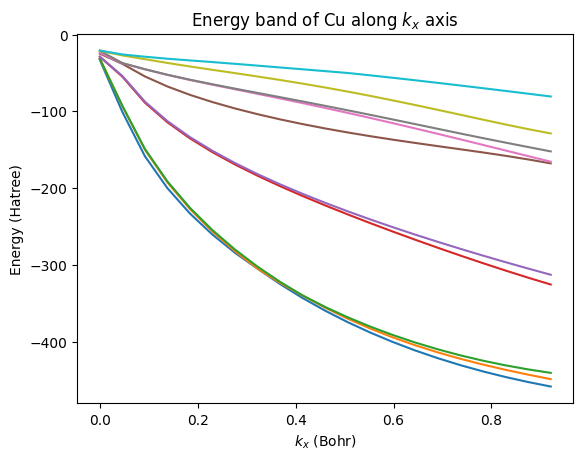

In [ ]:
#Graphs 
kx = list(map(lambda k: k[0],ks2))

for i in range(10):
    plt.plot(kx,Es2[:,i])
plt.title(r"Energy band of Cu along $k_x$ axis")
plt.xlabel(r"$k_x$ (Bohr)")
plt.ylabel("Energy (Hatree)")
plt.show()